# 生成数据集

In [7]:
import sqlite3
import pandas as pd
import json

# 连接 SQLite 数据库
db_path = "latest.db"  # 替换为实际路径
conn = sqlite3.connect(db_path)

# 1. 筛选 BIOG_MAIN 中满足条件的 c_personid 及其他信息
query_biog_main = """
SELECT c_personid, c_female, c_ethnicity_code, c_household_status_code, c_choronym_code
FROM BIOG_MAIN
WHERE c_dy = 20
"""
biog_main = pd.read_sql(query_biog_main, conn)

# 填充缺失值
biog_main['c_female'] = biog_main['c_female'].fillna(0).astype(int)
biog_main['c_ethnicity_code'] = biog_main['c_ethnicity_code'].fillna(0).astype(int)
biog_main['c_household_status_code'] = biog_main['c_household_status_code'].fillna(0).astype(int)
biog_main['c_choronym_code'] = biog_main['c_choronym_code'].fillna(0).astype(int)

# 2. 获取 ENTRY_DATA 中 c_personid 对应的 c_entry_code
query_entry_data = """
SELECT c_personid, c_entry_code
FROM ENTRY_DATA
"""
entry_data = pd.read_sql(query_entry_data, conn)

# 聚合 ENTRY_DATA 中同一 c_personid 的 c_entry_code
entry_data_agg = entry_data.groupby('c_personid')['c_entry_code'].agg(list).reset_index()

# 合并入仕信息
biog_main = biog_main.merge(entry_data_agg, on='c_personid', how='left')
biog_main['c_entry_code'] = biog_main['c_entry_code'].apply(lambda x: x if isinstance(x, list) else [-1])  # 填充缺失值

# 3. 获取 KIN_DATA 中 c_personid 对应的 c_kin_id 和 c_kin_code
query_kin_data = """
SELECT c_personid, c_kin_id, c_kin_code
FROM KIN_DATA
"""
kin_data = pd.read_sql(query_kin_data, conn)

# 填充缺失值
kin_data['c_kin_id'] = kin_data['c_kin_id'].fillna(-1).astype(int)
kin_data['c_kin_code'] = kin_data['c_kin_code'].fillna(-1).astype(int)

# 4. 获取 KINSHIP_CODES 中 c_kin_code 对应的 c_kinrel, c_kin_pair1 和 c_kin_pair2
query_kinship_codes = """
SELECT c_kincode, c_kinrel, c_kin_pair1, c_kin_pair2
FROM KINSHIP_CODES
"""
kinship_codes = pd.read_sql(query_kinship_codes, conn)

# 填充缺失值，保留 c_kinrel 为字符型，默认值为 'U'
kinship_codes['c_kinrel'] = kinship_codes['c_kinrel'].fillna('U').astype(str)
kinship_codes['c_kin_pair1'] = kinship_codes['c_kin_pair1'].fillna(-1).astype(int)
kinship_codes['c_kin_pair2'] = kinship_codes['c_kin_pair2'].fillna(-1).astype(int)

# 关闭数据库连接
conn.close()

# 5. 整合信息到 JSON 格式
result = []
for _, row in biog_main.iterrows():
    person_data = {
        "c_personid": int(row['c_personid']),
        "c_female": int(row['c_female']),
        "c_ethnicity_code": int(row['c_ethnicity_code']),
        "c_household_status_code": int(row['c_household_status_code']),  
        "c_choronym_code": int(row['c_choronym_code']),
        "c_entry_code": row['c_entry_code'],  # 保持 c_entry_code 为列表形式
        "kinships": [],
        "c_kin_existence": 0  # 初始化 c_kin_existence 为 0
    }

    # 获取当前 c_personid 的家庭信息
    person_kin_data = kin_data[kin_data['c_personid'] == row['c_personid']]
    if person_kin_data.empty:
        person_data["c_kin_existence"] = 0  # 无家庭信息，c_kin_existence 为 0
    else:
        person_data["c_kin_existence"] = 1  # 有家庭信息，c_kin_existence 为 1

    for _, kin_row in person_kin_data.iterrows():
        kin_code = int(kin_row['c_kin_code'])
        kin_info = {
            "c_kin_id": int(kin_row['c_kin_id']),
            "c_kin_code": kin_code,
            "c_kinrel": 'U',  # 初始化为缺失值
            "c_kin_pair1": -2,  # 初始化为缺失值
            "c_kin_pair2": -2  # 初始化为缺失值
        }

        # 获取 c_kin_code 对应的亲属关系信息
        kinship_info = kinship_codes[kinship_codes['c_kincode'] == kin_code]
        if not kinship_info.empty:
            kin_info['c_kinrel'] = kinship_info.iloc[0]['c_kinrel']  # 直接获取字符型值
            kin_info['c_kin_pair1'] = int(kinship_info.iloc[0]['c_kin_pair1'])
            kin_info['c_kin_pair2'] = int(kinship_info.iloc[0]['c_kin_pair2'])

        person_data["kinships"].append(kin_info)

    result.append(person_data)

# 6. 写入 JSON 文件
with open("large_all_data.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

print("JSON 文件生成成功：large_all_data.json")


JSON 文件生成成功：large_all_data.json


# 加载文件形成图结构

In [15]:
import json
import dgl
import torch

# 加载 JSON 文件
file_path = "large_all_data.json"  # 替换为实际文件路径
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 构建节点和边数据
node_ids = []  # 所有的 c_personid
kin_ids = set()  # 所有的 c_kin_id
node_features = {
    "c_female": [],
    "c_ethnicity_code": [],
    "c_household_status_code": [],
    "c_choronym_code": [],
    "c_entry_code_status": []
}
edges_src = []  # 边的起点
edges_dst = []  # 边的终点
edge_features = {
    "c_kinrel": []  # 边的特征
}

# 遍历 JSON 数据构建节点和边
for person in data:
    c_personid = person.get("c_personid", -1)  # 默认值 -1
    if c_personid != -1:
        node_ids.append(c_personid)
        node_features["c_female"].append(person.get("c_female", 0))
        node_features["c_ethnicity_code"].append(person.get("c_ethnicity_code", 0))
        node_features["c_household_status_code"].append(person.get("c_household_status_code", 0))
        node_features["c_choronym_code"].append(person.get("c_choronym_code", 0))

        # 判断入仕状态：c_entry_code 中只要有一个非负值则视为入仕
        c_entry_code = person.get("c_entry_code", [-2])  # 如果缺失，填充为 [-2]
        if any(code >= 0 for code in c_entry_code):
            node_features["c_entry_code_status"].append(1)  # 入仕
        else:
            node_features["c_entry_code_status"].append(0)  # 未入仕

        # 获取 c_kin_existence，决定是否添加边或自环
        c_kin_existence = person.get("c_kin_existence", 0)  # 缺失默认为 0
        if c_kin_existence == 1:  # 有家庭信息，处理 kinships
            for kinship in person.get("kinships", []):
                kin_id = kinship.get("c_kin_id", -1)
                if kin_id != -1:
                    edges_src.append(c_personid)
                    edges_dst.append(kin_id)
                    edge_features["c_kinrel"].append(kinship.get("c_kinrel", "U"))  # 默认值 "U"
                    kin_ids.add(kin_id)  # 记录 kin_id
        else:  # 无家庭信息，添加自环
            edges_src.append(c_personid)
            edges_dst.append(c_personid)
            edge_features["c_kinrel"].append("SELF")  # 自环标记

# 输出初步边统计
print(f"初步边统计 - 边数: {len(edges_src)} (起点), {len(edges_dst)} (终点)")

# 构建 node_id_map 和 kin_id_map
node_id_map = {nid: idx for idx, nid in enumerate(node_ids)}
kin_id_map = {kid: idx + len(node_id_map) for idx, kid in enumerate(kin_ids)}
node_id_map.update(kin_id_map)

# 更新 node_features 的长度以匹配所有节点
total_nodes = len(node_id_map)
for feature_name in node_features:
    while len(node_features[feature_name]) < total_nodes:
        node_features[feature_name].append(0)  # 填充默认值

# 验证节点特征长度
for feature_name, feature_values in node_features.items():
    print(f"节点特征 '{feature_name}' 的数量: {len(feature_values)}, 总节点数: {total_nodes}")
    assert len(feature_values) == total_nodes, f"节点特征 '{feature_name}' 长度不匹配!"

# 构建边索引
valid_edges_src, valid_edges_dst, valid_edge_features = [], [], []
for src, dst, rel in zip(edges_src, edges_dst, edge_features["c_kinrel"]):
    if src in node_id_map and dst in node_id_map:
        valid_edges_src.append(node_id_map[src])
        valid_edges_dst.append(node_id_map[dst])
        valid_edge_features.append(rel)

# 检查边索引的映射范围
print(f"节点总数：{total_nodes}")
print(f"有效边统计 - 边数: {len(valid_edges_src)} (起点), {len(valid_edges_dst)} (终点)")
assert len(valid_edges_src) == len(valid_edges_dst), "Source and destination nodes' lengths do not match"

# 创建图
g = dgl.graph((valid_edges_src, valid_edges_dst))

# 添加节点特征到图
for feature_name, feature_values in node_features.items():
    g.ndata[feature_name] = torch.tensor(feature_values, dtype=torch.long if feature_name != "c_entry_code_status" else torch.float)

# 添加边特征到图
g.edata["c_kinrel"] = torch.tensor([ord(rel[0]) if rel != "SELF" else -1 for rel in valid_edge_features], dtype=torch.float)

# 输出图的基本信息
print("图的节点数：", g.num_nodes())
print("图的边数：", g.num_edges())
for feature_name in node_features.keys():
    print(f"{feature_name} 特征：", g.ndata[feature_name].shape)
print("c_kinrel 边特征：", g.edata["c_kinrel"].shape)


初步边统计 - 边数: 251456 (起点), 251456 (终点)
节点特征 'c_female' 的数量: 229481, 总节点数: 229481
节点特征 'c_ethnicity_code' 的数量: 229481, 总节点数: 229481
节点特征 'c_household_status_code' 的数量: 229481, 总节点数: 229481
节点特征 'c_choronym_code' 的数量: 229481, 总节点数: 229481
节点特征 'c_entry_code_status' 的数量: 229481, 总节点数: 229481
节点总数：229481
有效边统计 - 边数: 251456 (起点), 251456 (终点)


DGLError: Expect number of features to match number of nodes (len(u)). Got 229481 and 258197 instead.

In [7]:
# 统计边的数量
num_edges_src = len(edges_src)
num_edges_dst = len(edges_dst)

# 统计自环的数量
self_loops = sum(1 for src, dst in zip(edges_src, edges_dst) if src == dst)

# 打印统计信息
print(f"Number of edges in edges_src: {num_edges_src}")
print(f"Number of edges in edges_dst: {num_edges_dst}")
print(f"Number of self-loops: {self_loops}")

# 检查 edges_src 和 edges_dst 是否长度匹配
if num_edges_src != num_edges_dst:
    print("Warning: edges_src and edges_dst lengths do not match!")


Number of edges in edges_src: 251456
Number of edges in edges_dst: 251456
Number of self-loops: 199482


In [5]:
import json
import dgl
import torch

# 加载 JSON 文件
with open("conservative_all_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 统计 kinships 为空的节点数量
total_nodes = len(data)
data_with_kinships = [person for person in data if len(person.get("kinships", [])) > 0]
nodes_without_kinships = total_nodes - len(data_with_kinships)
proportion_without_kinships = nodes_without_kinships / total_nodes

print(f"Total nodes: {total_nodes}")
print(f"Nodes without kinships: {nodes_without_kinships}")
print(f"Proportion of nodes without kinships: {proportion_without_kinships:.2%}")

# 跳过 kinships 为空的观测
data = data_with_kinships

# 构建 node_id_map，确保所有 c_personid 和 c_kin_id 都被映射
node_ids = []         # 所有的 c_personid
kin_ids = set()      # 所有的 c_kin_id（去重）
node_labels = []     # 节点标签
entry_code_features = []   # 存储 c_entry_code 特征
kinship_count_features = []  # 存储 kinships 数量特征

# 遍历 JSON 数据，构建节点和边
for person in data:
    # 添加节点 ID
    node_ids.append(person["c_personid"])

    # 处理入仕标签：检查 c_entry_code 列表中是否有非负值
    c_entry_code = person["c_entry_code"]
    if any(code >= 0 for code in c_entry_code):  # 只要有一个非负值，就视为入仕
        node_labels.append(1)  # 入仕，标签为 1
    else:
        node_labels.append(0)  # 未入仕，标签为 0

    # 提取 c_entry_code 特征：如果有值，则选择第一个有效的（或者填充为 -2）
    entry_code_feature = c_entry_code[0] if c_entry_code else -2
    entry_code_features.append([entry_code_feature])

    # 计算 kinships 数量
    kinship_count_features.append([len(person.get("kinships", []))])

    # 添加 kin_ids
    for kinship in person.get("kinships", []):
        kin_ids.add(kinship["c_kin_id"])

# 构建 node_id_map，确保所有的 c_personid 和 c_kin_id 都在映射中
node_id_map = {nid: idx for idx, nid in enumerate(node_ids)}
kin_id_map = {kin_id: idx + len(node_id_map) for idx, kin_id in enumerate(kin_ids)}  # 确保 kin_id 从 node_id_map 后面开始

# 合并 node_id_map 和 kin_id_map
node_id_map.update(kin_id_map)

# 创建图
edges_src = []        # 边的起点
edges_dst = []        # 边的终点

# 遍历数据构建边，并模拟无向图（双向边）
for person in data:
    for kinship in person.get("kinships", []):
        src_node = person["c_personid"]
        dst_node = kinship["c_kin_id"]

        # 仅添加有效的边
        if src_node in node_id_map and dst_node in node_id_map:
            edges_src.append(node_id_map[src_node])
            edges_dst.append(node_id_map[dst_node])

            # 添加反向边，模拟无向图
            edges_src.append(node_id_map[dst_node])
            edges_dst.append(node_id_map[src_node])

# 确保 `edges_src` 和 `edges_dst` 的长度一致
assert len(edges_src) == len(edges_dst), "Source and destination nodes' lengths do not match"

# 构建图
g = dgl.graph((edges_src, edges_dst))

# 填充缺失的节点标签和特征，直到它们的数量与图的节点数一致
while len(node_labels) < g.num_nodes():
    node_labels.append(0)  # 填充为默认标签 0（未入仕）

while len(entry_code_features) < g.num_nodes():
    entry_code_features.append([-2])  # 填充为默认特征值 [-2]（无入仕信息）

while len(kinship_count_features) < g.num_nodes():
    kinship_count_features.append([0])  # 填充为默认特征值 0（无家庭关系）

# 设置节点标签和特征
g.ndata['label'] = torch.tensor(node_labels)  # 填充后的标签
g.ndata['entry_code_feat'] = torch.tensor(entry_code_features, dtype=torch.float)  # c_entry_code 特征
g.ndata['kinship_count_feat'] = torch.tensor(kinship_count_features, dtype=torch.float)  # kinships 数量特征

# 输出图的基本信息
print("图的节点数：", g.num_nodes())
print("图的边数：", g.num_edges())
print("c_entry_code 特征：", g.ndata['entry_code_feat'].shape)
print("kinships 数量特征：", g.ndata['kinship_count_feat'].shape)
print("节点标签：", g.ndata['label'].shape)


Total nodes: 228527
Nodes without kinships: 199471
Proportion of nodes without kinships: 87.29%
图的节点数： 58726
图的边数： 103970
c_entry_code 特征： torch.Size([58726, 1])
kinships 数量特征： torch.Size([58726, 1])
节点标签： torch.Size([58726])


# 对图的一些统计

In [29]:
# 构图完成后重新统计入仕者比例
entry_code_feat = g.ndata['entry_code_feat'].numpy()
total_nodes_in_graph = g.num_nodes()
positive_nodes_in_graph = sum(1 for feat in entry_code_feat if feat[0] >= 0)
positive_ratio_in_graph = positive_nodes_in_graph / total_nodes_in_graph

print(f"Total nodes in graph: {total_nodes_in_graph}")
print(f"Positive nodes (入仕者数量): {positive_nodes_in_graph}")
print(f"入仕者比例: {positive_ratio_in_graph:.2%}")


Total nodes in graph: 3026
Positive nodes (入仕者数量): 212
入仕者比例: 7.01%


In [30]:
# 先打印一些边信息
print(f"First 5 edges: {list(zip(edges_src, edges_dst))[:5]}")
print(f"Total number of edges: {len(edges_src)}")

# 查看节点入度信息
for node in range(g.num_nodes()):
    print(f"Node {node} in-degree: {g.in_degrees(node)}")


First 5 edges: [(1905, 1891), (1905, 1892), (1905, 2795), (1835, 1846), (1835, 1861)]
Total number of edges: 3017
Node 0 in-degree: 0
Node 1 in-degree: 0
Node 2 in-degree: 0
Node 3 in-degree: 0
Node 4 in-degree: 0
Node 5 in-degree: 0
Node 6 in-degree: 0
Node 7 in-degree: 0
Node 8 in-degree: 0
Node 9 in-degree: 0
Node 10 in-degree: 0
Node 11 in-degree: 0
Node 12 in-degree: 0
Node 13 in-degree: 0
Node 14 in-degree: 0
Node 15 in-degree: 0
Node 16 in-degree: 0
Node 17 in-degree: 0
Node 18 in-degree: 0
Node 19 in-degree: 0
Node 20 in-degree: 0
Node 21 in-degree: 0
Node 22 in-degree: 0
Node 23 in-degree: 0
Node 24 in-degree: 0
Node 25 in-degree: 0
Node 26 in-degree: 0
Node 27 in-degree: 0
Node 28 in-degree: 0
Node 29 in-degree: 0
Node 30 in-degree: 0
Node 31 in-degree: 0
Node 32 in-degree: 0
Node 33 in-degree: 0
Node 34 in-degree: 0
Node 35 in-degree: 0
Node 36 in-degree: 0
Node 37 in-degree: 0
Node 38 in-degree: 0
Node 39 in-degree: 0
Node 40 in-degree: 0
Node 41 in-degree: 0
Node 42 in-deg

# 建模

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn

# 定义 GCN 模型
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        # 图卷积层（减少了卷积层的数量）
        self.conv1 = dglnn.GraphConv(in_feats, hidden_feats, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_feats, out_feats, allow_zero_in_degree=True)

    def forward(self, g, features):
        # 第一层图卷积
        h = self.conv1(g, features)
        h = F.relu(h)
        # 第二层图卷积
        h = self.conv2(g, h)
        return h

# 参数设置
in_feats = 2  # 输入特征维度（c_entry_code 和 kinships 数量）
hidden_feats = 8  # 减小隐藏层特征维度
out_feats = 2  # 输出类别数（这里是2，假设是二分类任务）

# 实例化模型
model = GCN(in_feats, hidden_feats, out_feats)

# 选择优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # 使用较低的学习率

# 准备数据
features = torch.cat((g.ndata['entry_code_feat'], g.ndata['kinship_count_feat']), dim=1)  # 合并两个特征
labels = g.ndata['label']  # 节点标签

# 将数据集划分为训练集和测试集
train_mask = torch.randint(0, 2, (g.num_nodes(),)).bool()  # 随机划分训练数据
train_labels = labels[train_mask]  # 训练标签
train_features = features[train_mask]  # 训练特征

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # 前向传播
    logits = model(g, features)
    
    # 计算损失（这里使用交叉熵损失）
    loss = F.cross_entropy(logits[train_mask], train_labels)
    loss.backward()
    optimizer.step()

    # 输出每轮的损失
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# 模型评估
model.eval()
with torch.no_grad():
    logits = model(g, features)
    pred = logits.argmax(dim=1)  # 预测标签
    print("Prediction:", pred)

# 输出模型的基本信息
print("Number of nodes in the graph:", g.num_nodes())
print("Number of edges in the graph:", g.num_edges())


Epoch 0, Loss: 0.7980528473854065
Epoch 10, Loss: 0.587593674659729
Epoch 20, Loss: 0.4498821794986725
Epoch 30, Loss: 0.37043213844299316
Epoch 40, Loss: 0.32710275053977966
Epoch 50, Loss: 0.302595317363739
Epoch 60, Loss: 0.2872304320335388
Epoch 70, Loss: 0.276373028755188
Epoch 80, Loss: 0.2679401934146881
Epoch 90, Loss: 0.2609660029411316
Prediction: tensor([0, 0, 0,  ..., 0, 0, 0])
Number of nodes in the graph: 58726
Number of edges in the graph: 103970


In [8]:
# 后
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn

# 定义 GCN 模型
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, dropout_rate=0.5):
        super(GCN, self).__init__()
        # 图卷积层
        self.conv1 = dglnn.GraphConv(in_feats, hidden_feats, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_feats, hidden_feats, allow_zero_in_degree=True)  # 增加额外的卷积层
        self.conv3 = dglnn.GraphConv(hidden_feats, out_feats, allow_zero_in_degree=True)  # 输出层

        # Dropout 层
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, g, features):
        # 第一层图卷积
        h = self.conv1(g, features)
        h = F.relu(h)
        h = self.dropout(h)  # 使用 Dropout 防止过拟合

        # 第二层图卷积
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.dropout(h)

        # 第三层图卷积（输出层）
        h = self.conv3(g, h)
        return h

# 参数设置
in_feats = 2  # 输入特征维度（c_entry_code 和 kinships 数量）
hidden_feats = 64  # 增加隐藏层特征维度
out_feats = 2  # 输出类别数（这里是2，假设是二分类任务）
dropout_rate = 0.5  # Dropout rate 用于防止过拟合

# 实例化模型
model = GCN(in_feats, hidden_feats, out_feats, dropout_rate)

# 选择优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 准备数据
features = torch.cat((g.ndata['entry_code_feat'], g.ndata['kinship_count_feat']), dim=1)  # 合并两个特征
labels = g.ndata['label']  # 节点标签

# 将数据集划分为训练集和测试集
train_mask = torch.randint(0, 2, (g.num_nodes(),)).bool()  # 随机划分训练数据
train_labels = labels[train_mask]  # 训练标签
train_features = features[train_mask]  # 训练特征

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # 前向传播
    logits = model(g, features)
    
    # 计算损失（这里使用交叉熵损失）
    loss = F.cross_entropy(logits[train_mask], train_labels)
    loss.backward()
    optimizer.step()

    # 输出每轮的损失
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# 模型评估
model.eval()
with torch.no_grad():
    logits = model(g, features)
    pred = logits.argmax(dim=1)  # 预测标签
    print("Prediction:", pred)

# 输出模型的基本信息
print("Number of nodes in the graph:", g.num_nodes())
print("Number of edges in the graph:", g.num_edges())


Epoch 0, Loss: 0.7192545533180237
Epoch 10, Loss: 0.3392474055290222
Epoch 20, Loss: 0.32370710372924805
Epoch 30, Loss: 0.29661473631858826
Epoch 40, Loss: 0.2727692425251007
Epoch 50, Loss: 0.2587529122829437
Epoch 60, Loss: 0.24855823814868927
Epoch 70, Loss: 0.239947110414505
Epoch 80, Loss: 0.23474426567554474
Epoch 90, Loss: 0.2307879477739334
Prediction: tensor([0, 0, 0,  ..., 0, 0, 0])
Number of nodes in the graph: 58726
Number of edges in the graph: 103970


# 验证结果

Test Accuracy: 92.70%
Precision: 0.9675
Recall: 0.0270
F1 Score: 0.0526
Confusion Matrix:
[[54320     4]
 [ 4283   119]]


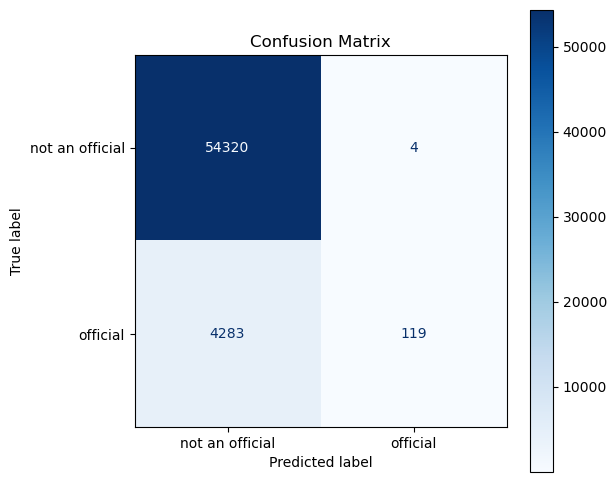

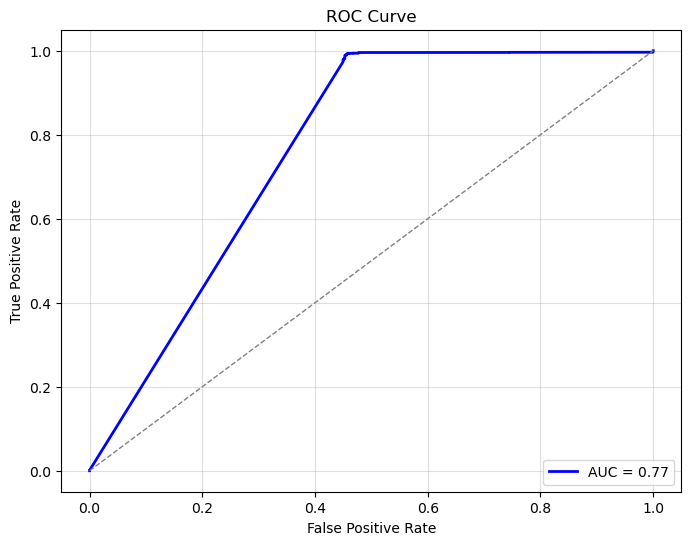

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# 设置模型为评估模式
model.eval()
with torch.no_grad():
    logits = model(g, features)  # 模型输出
    pred = logits.argmax(dim=1)  # 预测标签

    # 计算各项指标
    accuracy = accuracy_score(labels.numpy(), pred.numpy())
    precision = precision_score(labels.numpy(), pred.numpy(), average='binary')
    recall = recall_score(labels.numpy(), pred.numpy(), average='binary')
    f1 = f1_score(labels.numpy(), pred.numpy(), average='binary')
    conf_matrix = confusion_matrix(labels.numpy(), pred.numpy())

    # 获取 ROC 曲线和 AUC
    probs = logits[:, 1].numpy()  # 获取属于类别 1（入仕）的概率
    fpr, tpr, thresholds = roc_curve(labels.numpy(), probs)
    roc_auc = auc(fpr, tpr)

# 打印评估指标
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["not an official", "official"])
disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # 随机分类参考线
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()
